### Assessing dFC using individual methodologies

In this demo we will illustrate how to use each of the dFC assessment methods implemented in multi_analysis_dfc toolbox.

We use sample data from an openneuro dataset by: Lukas Snoek and Maite van der Miesen and Andries van der Leij and Tinka Beemsterboer and Annemarie Eigenhuis and Steven Scholte (2020). AOMIC-PIOP1. OpenNeuro. [Dataset] doi: 10.18112/openneuro.ds002785.v2.0.0

In [1]:
from multi_analysis_dfc import data_loader
import numpy as np
import warnings
warnings.simplefilter('ignore')

### State-free Methods

These methods do not require any model fitting or brain states estimation. Therefore, they can be simply applied on each single subject's data.

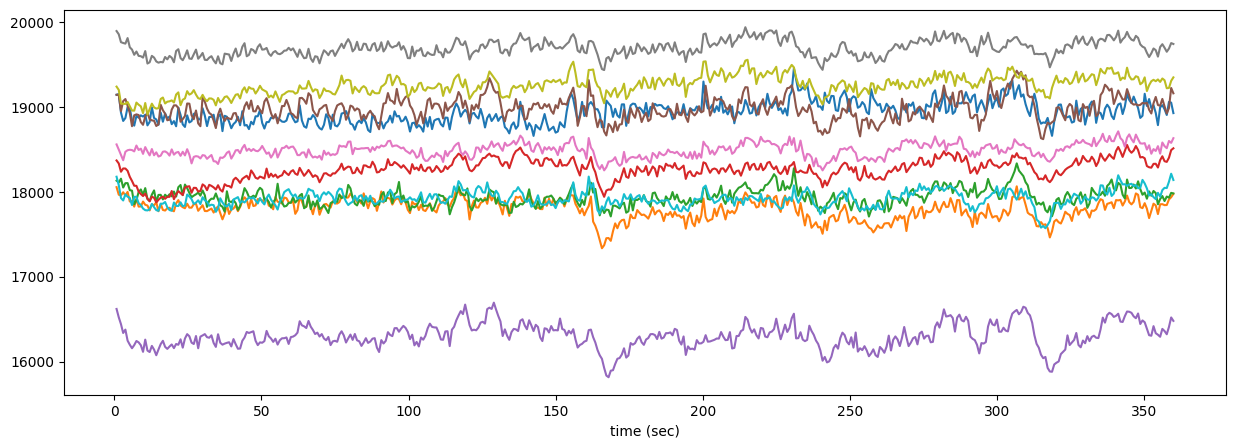

In [2]:
# load sub-0001 data from nifti file
BOLD = data_loader.nifti2timeseries(
            nifti_file='sample_data/sample_nifti_data/sub-0001_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
            n_rois=100, Fs=1/0.75,
            subj_id='sub-0001',
            confound_strategy='none', standardize=False,
            TS_name=None,
            session=None,
        )

BOLD.visualize( start_time=0, end_time=1000, nodes_lst=range(10))

#### Sliding Window (SW)

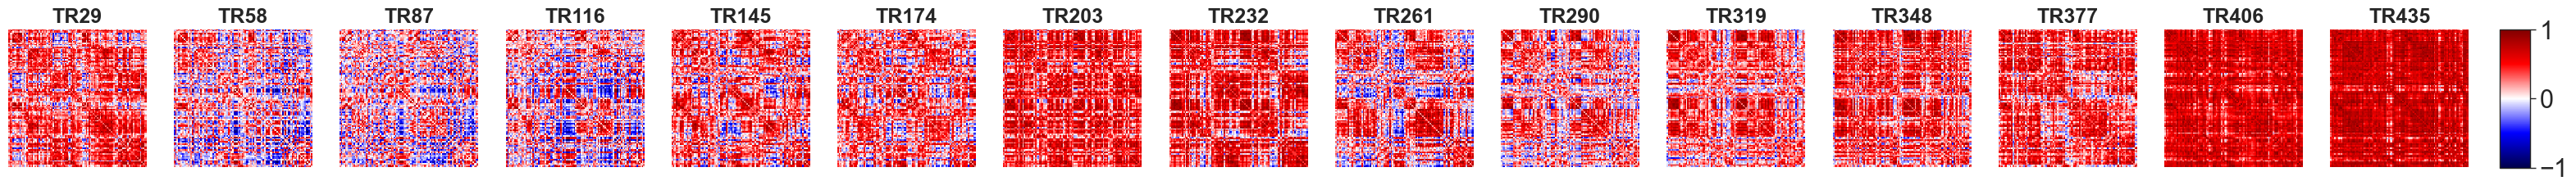

In [3]:
from multi_analysis_dfc.dfc_methods import SLIDING_WINDOW

params_methods = {
    # W is in sec
    'W': 44, 'n_overlap': 0.5, 'sw_method':'pear_corr', 'tapered_window':True, 
    # data Parameters
    'normalization': True, 
    'num_select_nodes': None, # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = SLIDING_WINDOW(**params_methods)
dFC = measure.estimate_dFC(time_series=BOLD)
dFC.visualize_dFC(TRs=dFC.TR_array[:], normalize=True, fix_lim=False)

#### Time-Frequency (TF)

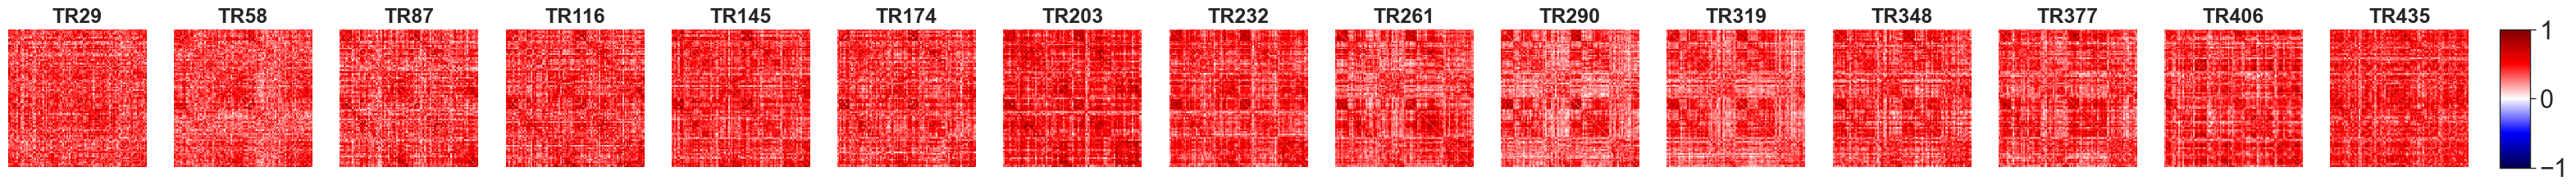

In [4]:
from multi_analysis_dfc.dfc_methods import TIME_FREQ

params_methods = {
    'TF_method':'WTC', 
    # Parallelization Parameters
    'n_jobs': 2, 'verbose': 0, 'backend': 'loky',
    # Data Parameters
    'normalization': True,
    'num_select_nodes': None, # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = TIME_FREQ(**params_methods)
dFC = measure.estimate_dFC(time_series=BOLD)
TRs = dFC.TR_array[np.arange(29, 480-29, 29)]
dFC.visualize_dFC(TRs=TRs, normalize=True, fix_lim=False)

### State-based Methods

The state-based methods require an initial model fitting and functional connectivity states (FCS) estimation on multiple or all subjects.

In [5]:
# loading data of multiple subjects from their niifti files
subj_id_list = ['sub-0001', 'sub-0002', 'sub-0003', 'sub-0004', 'sub-0005']
nifti_files_list = []
for subj_id in subj_id_list:
    nifti_files_list.append(
        'sample_data/sample_nifti_data/'+subj_id+'_task-restingstate_acq-mb3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    )

BOLD_multi = data_loader.multi_nifti2timeseries(
        nifti_files_list,
        subj_id_list,
        n_rois=100, Fs=1/0.75,
        confound_strategy='none', 
        standardize=False,
        TS_name=None,
        session=None,
)

#### Co-Activation Patterns (CAP)

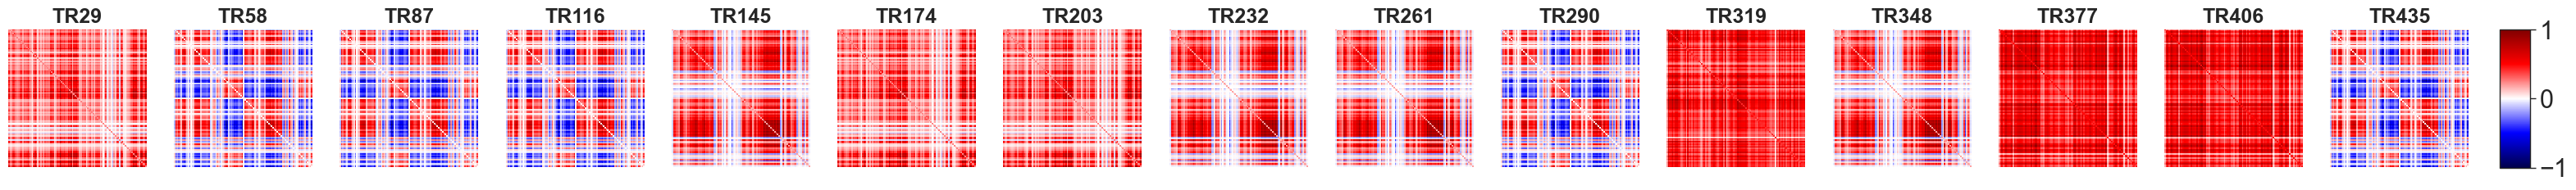

In [6]:
from multi_analysis_dfc.dfc_methods import CAP

params_methods = {
    # State Parameters
    'n_states': 12, 'n_subj_clstrs': 20,
    # Data Parameters
    'normalization': True,
    'num_subj': None, # you can make the number of subjects smaller, e.g. by setting to 2, for faster computation
    'num_select_nodes': None, # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = CAP(**params_methods)
measure.estimate_FCS(time_series=BOLD_multi)
dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id='sub-0001'))
TRs = dFC.TR_array[np.arange(29, 480-29, 29)]
dFC.visualize_dFC(TRs=TRs, normalize=True, fix_lim=False)

#### Sliding Window + Clustering (SWC)

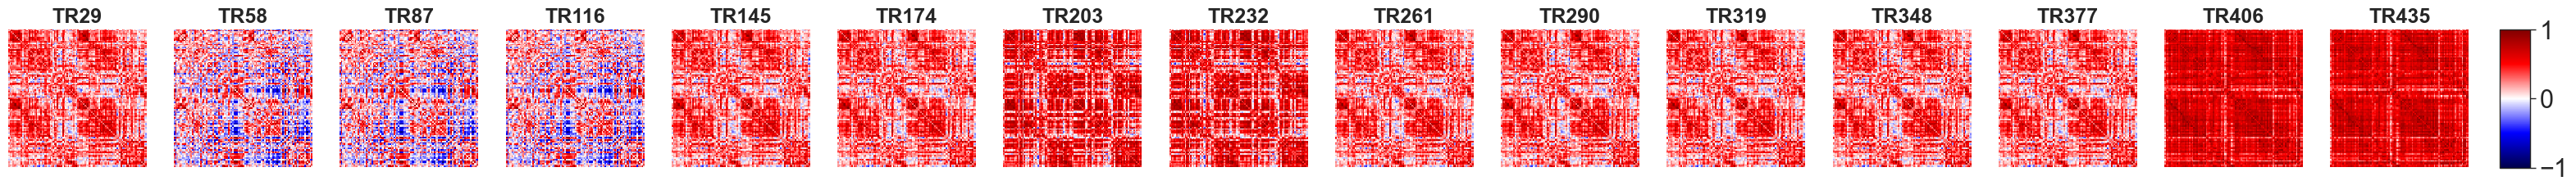

In [7]:
from multi_analysis_dfc.dfc_methods import SLIDING_WINDOW_CLUSTR

params_methods = {
    # Sliding Parameters
    # W is in sec
    'W': 44, 'n_overlap': 0.5, 'sw_method':'pear_corr', 'tapered_window':True, 
    # CLUSTERING 
    'clstr_base_measure':'SlidingWindow',
    # State Parameters
    'n_states': 12, 'n_subj_clstrs': 5,
    # Data Parameters
    'normalization': True,
    'num_subj': None, # you can make the number of subjects smaller, e.g. by setting to 2, for faster computation
    'num_select_nodes': None, # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = SLIDING_WINDOW_CLUSTR(**params_methods)
measure.estimate_FCS(time_series=BOLD_multi)
dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id='sub-0001'))
dFC.visualize_dFC(TRs=dFC.TR_array[:], normalize=True, fix_lim=False)

#### Continuous Hidden Markov Model (CHMM)

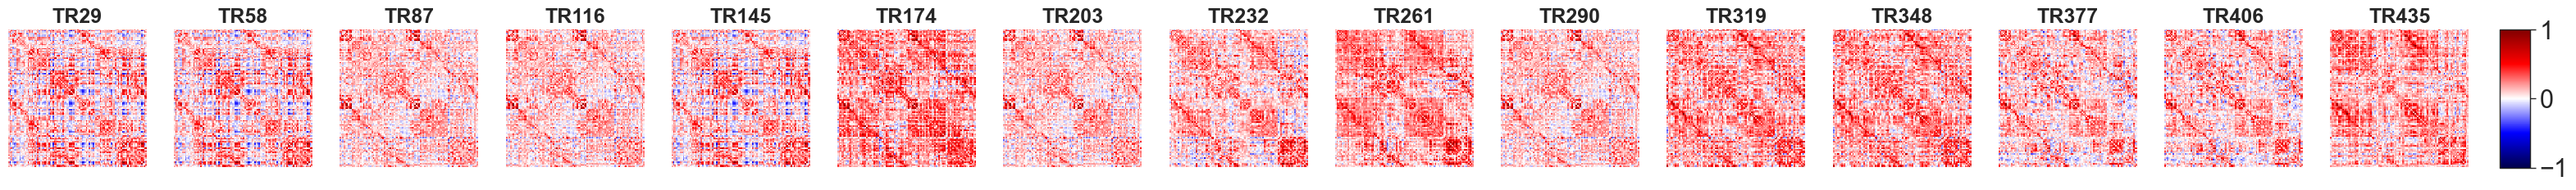

In [8]:
from multi_analysis_dfc.dfc_methods import HMM_CONT

params_methods = {
    # HMM
    'hmm_iter': 20,
    # State Parameters
    'n_states': 12,
    # Data Parameters
    'normalization': True,
    'num_subj': None, # you can make the number of subjects smaller, e.g. by setting to 2, for faster computation
    'num_select_nodes': None, # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = HMM_CONT(**params_methods)
measure.estimate_FCS(time_series=BOLD_multi)
dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id='sub-0001'))
TRs = dFC.TR_array[np.arange(29, 480-29, 29)]
dFC.visualize_dFC(TRs=TRs, normalize=True, fix_lim=False)

#### Discrete Hidden Markov Model (DHMM)

Note that 5 subjects is to small to fit the DHMM model. That is the reason the warning is raised.

Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
Fitting a model with 227 free scalar parameters with only 75 data points will result in a degenerate solution.
F

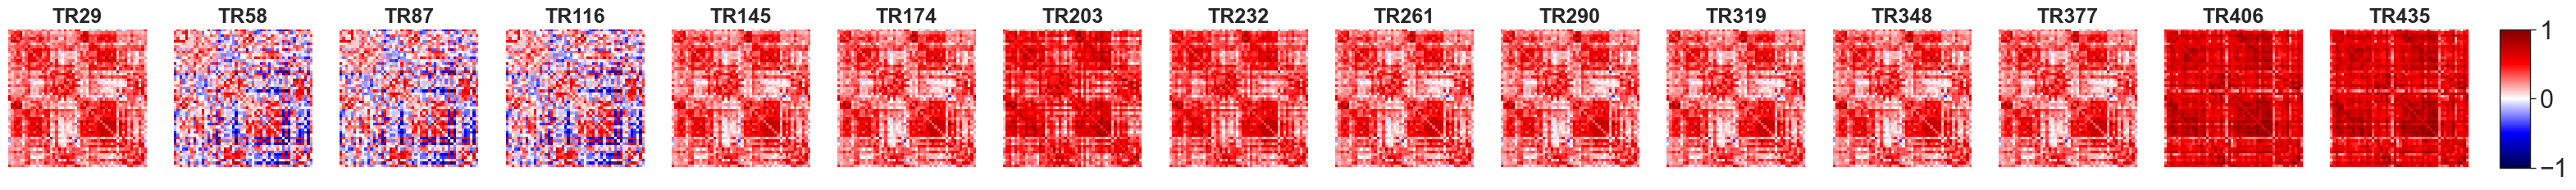

In [9]:
from multi_analysis_dfc.dfc_methods import HMM_DISC

params_methods = {
    # Sliding Parameters
    # W is in sec
    'W': 44, 'n_overlap': 0.5, 'sw_method':'pear_corr', 'tapered_window':True,
    # CLUSTERING AND DHMM
    'clstr_base_measure':'SlidingWindow',
    # HMM
    'hmm_iter': 20, 'dhmm_obs_state_ratio': 16/24, 
    # State Parameters
    'n_states': 12, 'n_subj_clstrs': 5,
    # Data Parameters
    'normalization': True,
    'num_subj': None, # you can make the number of subjects smaller, e.g. by setting to 2, for faster computation
    'num_select_nodes': 50, # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = HMM_DISC(**params_methods)
measure.estimate_FCS(time_series=BOLD_multi)
dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id='sub-0001'))
dFC.visualize_dFC(TRs=dFC.TR_array[:], normalize=True, fix_lim=False)

#### Window-less (WL)

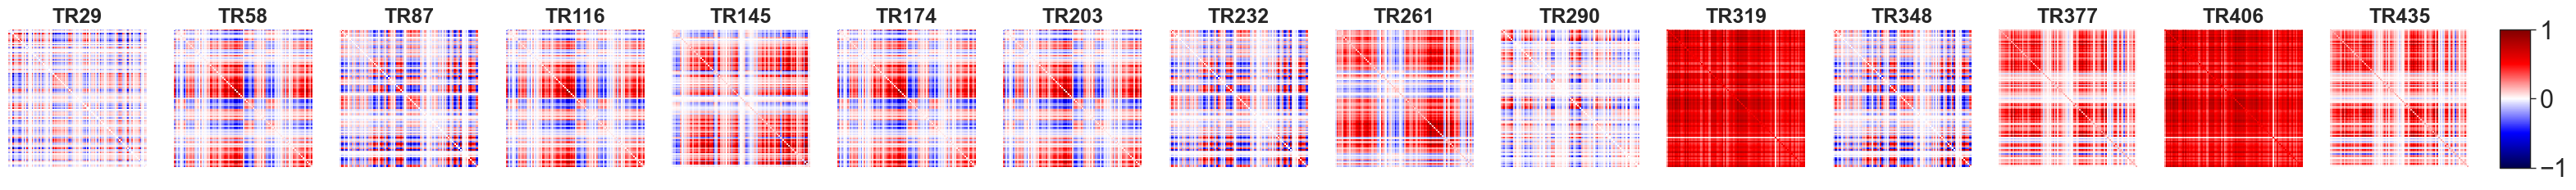

In [10]:
from multi_analysis_dfc.dfc_methods import WINDOWLESS

params_methods = {
    # State Parameters
    'n_states': 12,
    # Data Parameters
    'normalization': True,
    'num_subj': None, # you can make the number of subjects smaller, e.g. by setting to 2, for faster computation
    'num_select_nodes': None, # you can make the number of nodes smaller, e.g. by setting to 50, for faster computation
}

measure = WINDOWLESS(**params_methods)
measure.estimate_FCS(time_series=BOLD_multi)
dFC = measure.estimate_dFC(time_series=BOLD_multi.get_subj_ts(subjs_id='sub-0001'))
TRs = dFC.TR_array[np.arange(29, 480-29, 29)]
dFC.visualize_dFC(TRs=TRs, normalize=True, fix_lim=False)